### Imports

In [1]:
import warnings
import os
import glob
import numpy as np
import pandas as pd
import librosa as ls
import librosa.display as lsd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Specify parent directory containing audio and metadata

In [2]:
parent_dir = os.path.dirname('../UrbanSound8K/')

In [3]:
metadata = pd.read_csv(os.path.join(parent_dir, 'metadata/UrbanSound8K.csv'))

In [4]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
len(metadata)

8732

In [6]:
metadata.drop_duplicates('class')

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
22,100852-0-0-0.wav,100852,0.000000,4.000000,1,5,0,air_conditioner
94,101848-9-0-0.wav,101848,0.000000,4.000000,1,7,9,street_music
106,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot
114,102853-8-0-0.wav,102853,0.000000,4.000000,2,7,8,siren
122,102857-5-0-0.wav,102857,0.000000,4.000000,1,10,5,engine_idling
171,103074-7-0-0.wav,103074,3.341279,7.341279,1,1,7,jackhammer
196,103199-4-0-0.wav,103199,0.000000,4.000000,1,3,4,drilling


### Visualising the dataset

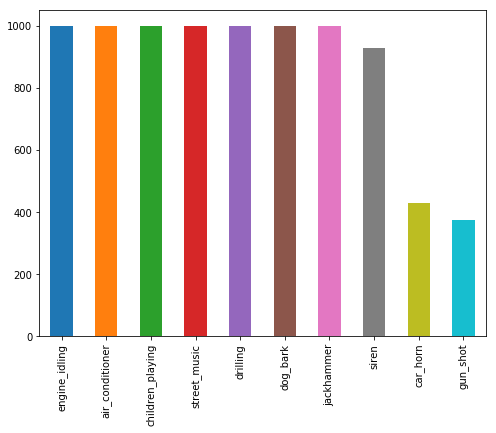

In [7]:
metadata['class'].value_counts().plot(kind='bar', figsize=(8,6))

In [8]:
sound_dir = os.path.join(parent_dir, 'audio')

### Feature extraction

CNN and RNN features are extracted as equal-sized segments from the sound clips. The CNN uses the melspecgram with segments of size 60X41 (60 rows/bands and 41 columns/frames), and a hop length of 512 (hop length is the number of samples between successive frames). The RNN uses mfcc with segments of 20X41 and a hop length of 512.

In [9]:
oof = open('file_exceptions.txt', 'w') # redirect error exceptions for make_features()

def windows(data, window_size):
    
    ' Generate equal-sized segments from the sounds (for CNN and RNN). '
    ' Sounds with a longer duration generate more features. '
    
    start = 0
    while start < len(data):
        yield start, start + window_size
        # For a window-size of 1024, hop-length of 512 is needed.
        start += (window_size / 2)

def make_features(data, cnnbands=60, rnnbands=20, frames=41, window_size=512*40):
    
    ' Extract features from sound files. '
    ' Three different types of features are extracted: '
    ' MLP: chroma, mfcc, tonnetz, melspecgram '
    ' CNN: segments of melspecgram '
    ' RNN: segments of mfcc '
    
    try:      
        # Load and decode the audio as:
        # 1) time series ts - a 1D array
        # 2) variable sr - sampling rate of ts (samples per second of audio).
        ts, sr = ls.load(data, res_type='kaiser_fast') 
        
        # Compute the short-time Fourier transform (stft):
        # 1) divide a longer time signal into shorter segments of equal length
        # 2) map to a sinusoidal basis.
        # Output is a matrix D(f,t) such that |D(f,t)| is the magnitude of frequency bin f at time t.
        stft = np.abs(ls.stft(ts))

        # Note that for "mel" and "mfcc" features, spectra are mapped to the mel basis.
        # This approximates the mapping of frequqncies to patches of nerves in the cochlea.
        # Doing so lets you use spectral information in about the same way as human hearing.
        
        # Project the entire spectrum onto 12 bins representing the 12 semitones of the musical octave.
        # Then take the mean along each bin to generate 12 features.
        chroma = np.mean(ls.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        
        # Compute the mel-frequency cepstral coefficients (MFCC):
        # 1) map the powerspectrum of the stft onto the mel scale (pitch instead of frequency).
        # 2) take log of the powers at each frequency.
        # 3) take a cosine transform of these log powers.
        # 4) MFCCs are the amplitudes of the resulting spectrum, shape=[n_mfcc,time].
        # Then take the mean along the first axis, generating 40 features.
        mfcc = np.mean(ls.feature.mfcc(y=ts, sr=sr, n_mfcc=40).T, axis=0)
        
        # Compute tonal centroid features by transforming the 12 bin chromas to 6D vectors.
        # Then take the mean along each dimension to generate 6 features. 
        tonnetz = np.mean(ls.feature.tonnetz(y=ls.effects.harmonic(ts), sr=sr).T, axis=0)
        
        # Compute the spectogram of the stft and map to the mel scale, shape=[n_mels,time].
        # Then take the mean along the first axis, generating 128 features.
        mel = np.mean(ls.feature.melspectrogram(ts, sr=sr).T,axis=0)
        
        # So far the total number of features is 12+40+6+128 = 186 features. 
        # These will be the features used in the Multilayer Perceptron model.
        mlpfeatures = np.concatenate([chroma,mfcc,tonnetz,mel])

        # For CNN and RNN, features are extracted from equal-sized segments of the sound clips.
        # CNN features are just the mel spectrograms (based off the paper linked above).
        # RNN features are the MFCCs (in an effort to try different features than CNN's).
        
        # CNN features
        specgrams = []
        for start,end in windows(ts,window_size):
            start = int(start)
            end = int(end)
            if len(ts[start:end]) == window_size :
                signal = ts[start:end]
                melspec = ls.feature.melspectrogram(signal, n_mels=cnnbands)
                melspec = ls.amplitude_to_db(melspec) # logarithmic units
                melspec = melspec.T.flatten()[:, np.newaxis].T # expand dim to help with reshaping
                specgrams.append(melspec)
        specgrams = np.asarray(specgrams).reshape(len(specgrams),cnnbands,frames,1)
        cnnfeatures = np.concatenate((specgrams, np.zeros(np.shape(specgrams))), axis=3)
        for i in range(len(cnnfeatures)):
            # Estimate first-order derivatives of each feature dimension.
            # This will be the second channel for CNN features.
            cnnfeatures[i, :, :, 1] = ls.feature.delta(cnnfeatures[i, :, :, 0])

        # RNN features
        mfccs = []
        for start,end in windows(ts,window_size):
            start = int(start)
            end = int(end)
            if len(ts[start:end]) == window_size :
                signal = ts[start:end]
                rnn_mfcc = ls.feature.mfcc(y=signal, sr=sr, n_mfcc=rnnbands)
                rnn_mfcc = rnn_mfcc.T.flatten()[:, np.newaxis].T
                mfccs.append(rnn_mfcc)
        rnnfeatures = np.asarray(mfccs).reshape(len(mfccs),rnnbands,frames)

        return mlpfeatures,cnnfeatures,rnnfeatures
    
    except Exception as e:
        # print to file f
        print(os.path.basename(os.path.normpath(data)), file=oof)
        

def make_labels(data):
    
    ' Extract target class from the filepath. '
    
    label = data.split('-')[1]
    return int(label)

In [10]:
example = os.path.join(sound_dir, 'fold1/7383-3-0-0.wav')

In [11]:
print("file path =", example)
print('')
print("label:", make_labels(example))
featmlp = make_features(example)[0]
print('MLP features shape:', featmlp.shape)
featcnn = make_features(example)[1]
print('CNN features shape:', featcnn.shape)
featrnn = make_features(example)[2]
print('RNN features shape:', featrnn.shape)

file path = ../UrbanSound8K/audio/fold1/7383-3-0-0.wav

label: 3
MLP features shape: (186,)
CNN features shape: (7, 60, 41, 2)
RNN features shape: (7, 20, 41)


In [12]:
file_extension='*.wav'
sub_dirs=['fold1','fold2','fold3','fold4','fold5','fold6','fold7','fold8','fold9','fold10']

In [13]:
sounds=[]
for i, sub_dir in enumerate(sub_dirs):
    for filename in glob.glob(os.path.join(sound_dir,sub_dir,file_extension)):
        sounds.append(filename)

In [18]:
sounds[-10::]

['../UrbanSound8K/audio/fold10/118558-5-2-1.wav',
 '../UrbanSound8K/audio/fold10/178826-2-0-17.wav',
 '../UrbanSound8K/audio/fold10/73524-0-0-105.wav',
 '../UrbanSound8K/audio/fold10/136558-9-1-21.wav',
 '../UrbanSound8K/audio/fold10/93567-8-0-13.wav',
 '../UrbanSound8K/audio/fold10/88121-8-0-0.wav',
 '../UrbanSound8K/audio/fold10/189982-0-0-42.wav',
 '../UrbanSound8K/audio/fold10/74364-8-1-7.wav',
 '../UrbanSound8K/audio/fold10/99192-4-0-7.wav',
 '../UrbanSound8K/audio/fold10/101382-2-0-33.wav']

In [15]:
warnings.filterwarnings("ignore")

# list of all .wav files in sound_dir
sounds=sounds

labels = []
mlpfeatures = []
cnnfeatures = []
rnnfeatures = []

# parsing each sound file to extract features and labels
for i in tqdm(range((len(sounds)))):
    audio_file = os.path.join(os.getcwd(), sounds[i])
    f = make_features(audio_file)
    if f is not None and len(f[0])>0 and len(f[1])>0 and len(f[2])>0:
        labels.append(make_labels(audio_file))
        mlpfeatures.append(np.array(f[0]))
        cnnfeatures.append(np.array(f[1]))
        rnnfeatures.append(np.array(f[2]))
oof.close()

labels = np.array(labels)
mlpfeatures = np.array(mlpfeatures)
cnnfeatures = np.array(cnnfeatures)
rnnfeatures = np.array(rnnfeatures)

100%|██████████| 8732/8732 [55:49<00:00,  2.49it/s] 


In [16]:
print('MLP features shape:', mlpfeatures.shape)
print('CNN features shape:', cnnfeatures.shape)
print('RNN features shape:', rnnfeatures.shape)

MLP features shape: (8319, 186)
CNN features shape: (8319,)
RNN features shape: (8319,)


In [17]:
[i.shape for i in cnnfeatures[:5]]

[(7, 60, 41, 2),
 (1, 60, 41, 2),
 (7, 60, 41, 2),
 (7, 60, 41, 2),
 (5, 60, 41, 2)]

In [18]:
[i.shape for i in rnnfeatures[:5]]

[(7, 20, 41), (1, 20, 41), (7, 20, 41), (7, 20, 41), (5, 20, 41)]

In [31]:
labelsFULL = []
cnnfeaturesFULL = []
rnnfeaturesFULL = []

for idx,item in enumerate(cnnfeatures):
    full = np.split(item, item.shape[0])
    for k in full:
        cnnfeaturesFULL.append(np.squeeze(k))
        labelsFULL.append(labels[idx])
for idx,item in enumerate(rnnfeatures):
    full = np.split(item, item.shape[0])
    for k in full:
        rnnfeaturesFULL.append(np.squeeze(k))

In [42]:
[i.shape for i in cnnfeaturesFULL[:10]]

[(60, 41, 2),
 (60, 41, 2),
 (60, 41, 2),
 (60, 41, 2),
 (60, 41, 2),
 (60, 41, 2),
 (60, 41, 2),
 (60, 41, 2),
 (60, 41, 2),
 (60, 41, 2)]

In [43]:
[i.shape for i in rnnfeaturesFULL[:10]]

[(20, 41),
 (20, 41),
 (20, 41),
 (20, 41),
 (20, 41),
 (20, 41),
 (20, 41),
 (20, 41),
 (20, 41),
 (20, 41)]

In [48]:
cnnfeaturesFULL = np.array(cnnfeaturesFULL)
rnnfeaturesFULL = np.array(rnnfeaturesFULL)

cnnfeaturesFULL.shape

(54058, 60, 41, 2)

Text(0.5,1,'distribution of target classes')

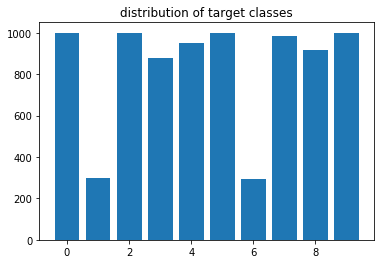

In [45]:
plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.8 )
plt.title('distribution of target classes')

In [39]:
n_classes = len(set(labels))
print('Labels')
print("Number of classes: \t%s" %(n_classes))

n_instances_mlp = mlpfeatures.shape[0]
n_inputs_mlp = mlpfeatures.shape[1]
print("")
print('MLP data')
print("Number of predictors: \t%s" %(n_inputs_mlp))
print("Number of instances: \t%s" %(n_instances_mlp))

n_instances_cnn = cnnfeaturesFULL.shape[0]
n_inputs_cnn = cnnfeaturesFULL.shape[1]*cnnfeaturesFULL.shape[2]
n_channels = cnnfeaturesFULL[0].shape[-1]
print("")
print('CNN data')
print("Number of predictors: \t%s" %(n_inputs_cnn))
print("Number of instances: \t%s" %(n_instances_cnn))
print("Number of channels: \t%s" %(n_channels))

n_instances_rnn = rnnfeaturesFULL.shape[0]
n_inputs_rnn = rnnfeaturesFULL.shape[1]
n_steps = rnnfeaturesFULL.shape[2]
print("")
print('RNN data')
print("Number of predictors: \t%s" %(n_inputs_rnn))
print("Number of instances: \t%s" %(n_instances_cnn))
print("Number of steps: \t%s" %(n_steps))
print("")

# rescaling to avoid geometric bias towards any MLP features
scaler = MinMaxScaler(feature_range=(0,1))
mlpfeatures = scaler.fit_transform(mlpfeatures)
print("Features ready")

# one-hot encoding for the audio classes
encoder = LabelBinarizer()
mlplabels = encoder.fit_transform(labels)
cnnlabels = encoder.fit_transform(labelsFULL)
rnnlabels = cnnlabels
print("Labels ready")

Labels
Number of classes: 	10

MLP data
Number of predictors: 	186
Number of instances: 	8319

CNN data
Number of predictors: 	2460
Number of instances: 	54058
Number of channels: 	2

RNN data
Number of predictors: 	20
Number of instances: 	54058
Number of steps: 	41

Features ready
Labels ready


In [40]:
# shuffle and split - stratified because of label imbalance
splitseed = 2
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=splitseed)
for train_index, test_index in sss.split(mlpfeatures, mlplabels):
    X_train_mlp, X_test_mlp = mlpfeatures[train_index], mlpfeatures[test_index]
    y_train_mlp, y_test_mlp = mlplabels[train_index], mlplabels[test_index]
for train_index, test_index in sss.split(cnnfeaturesFULL, cnnlabels):
    X_train_cnn, X_test_cnn = cnnfeaturesFULL[train_index], cnnfeaturesFULL[test_index]
    y_train_cnn, y_test_cnn = cnnlabels[train_index], cnnlabels[test_index]
for train_index, test_index in sss.split(rnnfeaturesFULL, rnnlabels):
    X_train_rnn, X_test_rnn = rnnfeaturesFULL[train_index], rnnfeaturesFULL[test_index]
    y_train_rnn, y_test_rnn = rnnlabels[train_index], rnnlabels[test_index]
    
print('MLP:')
print('Train set size: {0}'.format(X_train_mlp.shape[0]))
print('Test set size: {0}'.format(X_test_mlp.shape[0]))
print("")
print('CNN:')
print('Train set size: {0}'.format(X_train_cnn.shape[0]))
print('Test set size: {0}'.format(X_test_cnn.shape[0]))
print("")
print('RNN:')
print('Train set size: {0}'.format(X_train_rnn.shape[0]))
print('Test set size: {0}'.format(X_test_rnn.shape[0]))

MLP:
Train set size: 5823
Test set size: 2496

CNN:
Train set size: 37840
Test set size: 16218

RNN:
Train set size: 37840
Test set size: 16218


In [41]:
# save the train and test subsets for future use

np.save("X_train_mlp", X_train_mlp)
np.save("X_test_mlp", X_test_mlp)
np.save("y_train_mlp", y_train_mlp)
np.save("y_test_mlp", y_test_mlp)

np.save("X_train_cnn", X_train_cnn)
np.save("X_test_cnn", X_test_cnn)
np.save("y_train_cnn", y_train_cnn)
np.save("y_test_cnn", y_test_cnn)

np.save("X_train_rnn", X_train_rnn)
np.save("X_test_rnn", X_test_rnn)
np.save("y_train_rnn", y_train_rnn)
np.save("y_test_rnn", y_test_rnn)

print("Data saved")

Data saved
